---
title: "Modelos de árbol de decision"
date: 2022-04-09T11:39:36+02:00
tags: [decision tree models, ]
categories: [tutoriales]
---

En este post presentaremos en detalles los modelos de árbol de decisión, explicándolos tanto para problemas de clasificación como de regresión. También mostraremos qué hiperparámetros de los árboles de decisión tienen importancia en su rendimiento, permitiendo encontrar el mejor equilibrio entre underfitting y oberfitting.

# Arboles de decisión en clasificación

Vamos a explicar cómo usar árboles de decisión para entrenar datos usando un problema simple de clasificación usando el dataset de pingüinos.

In [1]:
import pandas as pd

penguins = pd.read_csv("../data/penguins_classification.csv")
culmen_columns = ["Culmen Length (mm)", "Culmen Depth (mm)"]
target_column = "Species"

También dividimos los datos en dos subconjuntos para investigar cómo los árboles predecirán valores basados en un dataset externo.

In [2]:
from sklearn.model_selection import train_test_split

X, y = penguins[culmen_columns], penguins[target_column]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

Un clasificador lineal definirá una separación lineal para dividir clases usando una combinación lineal de las variables de entrada. En nuestro espacio bidimensional, significa que un clasificador lineal definirá algunas líneas oblícuas que mejor separen nuestras clases. A continuación, definimos una función que, dado un conjunto de puntos de datos y un clasificador, dibujará los límites de decisión aprendidos por el clasificador.

Así, para un clasificador lineal, obtendremos los siguientes límites de decisión. Esas líneas límites indican dónde cambia el modelo su predicción de una clase a otra.

In [3]:
from sklearn.linear_model import LogisticRegression

linear_model = LogisticRegression()
linear_model.fit(X_train, y_train)

LogisticRegression()

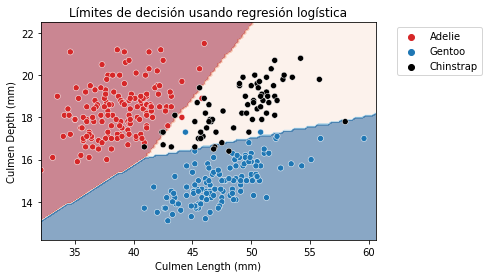

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

from helpers.plotting import DecisionBoundaryDisplay

palette = ["tab:red", "tab:blue", "black"]

DecisionBoundaryDisplay.from_estimator(
    linear_model, X_train, response_method="predict", cmap="RdBu", alpha=0.5
)
sns.scatterplot(data=penguins, x=culmen_columns[0], y=culmen_columns[1],
                hue=target_column, palette=palette)

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
_ = plt.title("Límites de decisión usando regresión logística")

Vemos que las líneas son una combinación de variables de entrada, dado que no son perpendiculares a ningún eje específico. De hecho, es debido a la parametrización del modelo, controlado por los pesos y la constante (intercept) del modelo.

Además, parece que el modelo lineal podría ser un buen candidato para este problema, ya que ofrece una buena precisión.

In [5]:
linear_model.fit(X_train, y_train)
test_score = linear_model.score(X_test, y_test)
print(f"Precisión de la regresión logística {test_score:.2f}")

Precisión de la regresión logística 0.98


A diferencia de los modelos lineales, los árboles de decisión son modelos no paramétricos: no están controlados por una función de decisión matemática y no tienen pesos o intercept que optimizar.

De hecho, los árboles de decisión dividen el espacio considerando una única feature a la vez. Vamos a ilustrar este comportamiento haciendo que un árbol de decisión haga una única división para particionar el espacio de features.

In [6]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(max_depth=1)
tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=1)

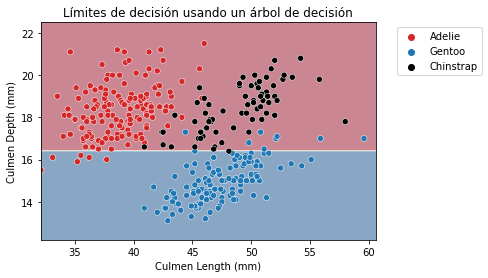

In [7]:
DecisionBoundaryDisplay.from_estimator(
    tree, X_train, response_method="predict", cmap="RdBu", alpha=0.5
)
sns.scatterplot(data=penguins, x=culmen_columns[0], y=culmen_columns[1],
                hue=target_column, palette=palette)

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
_ = plt.title("Límites de decisión usando un árbol de decisión")

Las particiones encontradas por el algoritmo separan los datos a los largo del eje "Culmen Depth", descartando la variable "Culmen Length". Por tanto, destacar que un árbol de decisión no usa una combinación de features cuando hace una división. Podemos ver más en profundidad la estructura de un árbol.

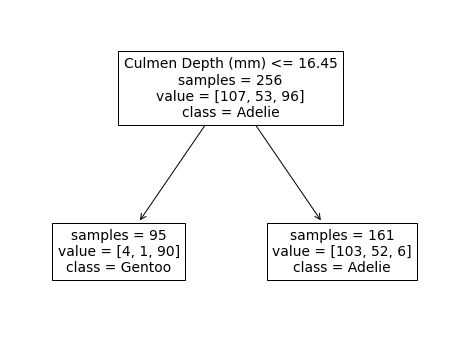

In [8]:
from sklearn.tree import plot_tree

_, ax = plt.subplots(figsize=(8, 6))
_ = plot_tree(tree, feature_names=culmen_columns,
              class_names=tree.classes_, impurity=False, ax=ax)

Vemos que la división se ha hecho a partir de la variable `culmen depth`. El dataset original se ha divididoen 2 conjuntos basados en la anchura del pico (inferior o superior a 16.45 mm).

Esta partición del dataset minimiza la diversidad de clases en cada subpartición. Esta medida también se conoce como **criterion**, y es un parámetro configurable.

Si miramos más de cerca la partición, vemos que la muestra superior a 16.45 pertenece principalmente a la clase Adelie. Mirando los valores, observamos 103 Adelie individuales en este espacio. También contamos 52 muestras de Chinstrap y 6 muestras de Gentoo. Podemos hacer una interpretación similar para la partición definida por un umbral inferior a 16.45 mm. En este caso, la clase más representativa es la especie Gentoo.

Veamos cómo trabaja nuestro árbol como predictor. Empecemos viendo la clase predicha cuando culmen depth es inferior al umbral.

In [9]:
sample_1 = pd.DataFrame(
    {"Culmen Length (mm)": [0], "Culmen Depth (mm)": [15]}
)
tree.predict(sample_1)

array(['Gentoo'], dtype=object)

La clase predicha es Gentoo. Ahora podemos verificar si pasamos a un culmen depth superior al umbral.

In [10]:
sample_2 = pd.DataFrame(
    {"Culmen Length (mm)": [0], "Culmen Depth (mm)": [17]}
)
tree.predict(sample_2)

array(['Adelie'], dtype=object)

En este caso el árbol predice la especie Adelie. Por tanto, podemos concluir que un clasificador de árbol de decisión predecirá la clase más representativa dentro de una partición. Durante el entrenamiento, tenemos un recuento de las muestras de cada partición y, por tanto, podemos calcular la probabilidad de pertenecer a una clase específica dentro de esa partición.

In [11]:
y_pred_proba = tree.predict_proba(sample_2)
y_proba_class_0 = pd.Series(y_pred_proba[0], index=tree.classes_)

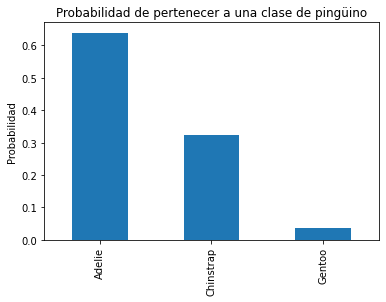

In [12]:
y_proba_class_0.plot.bar()
plt.ylabel("Probabilidad")
_ = plt.title("Probabilidad de pertenecer a una clase de pingüino")

Calcularemos manualmente las diferentes probabilidades directamente de la estructura del árbol.

In [13]:
adelie_proba = 103 / 161
chinstrap_proba = 52 / 161
gentoo_proba = 6 / 161
print(
    f"Probabilidades para las diferentes clases:\n"
    f"Adelie: {adelie_proba:.3f}\n"
    f"Chinstrap: {chinstrap_proba:.3f}\n"
    f"Gentoo: {gentoo_proba:.3f}"
)

Probabilidades para las diferentes clases:
Adelie: 0.640
Chinstrap: 0.323
Gentoo: 0.037


También es importante remarcar que culmen length ha sido descartada por el momento. Significa que cualquiera que sea el valor dado, no se usará durante la predicción.

In [14]:
sample_3 = pd.DataFrame(
    {"Culmen Length (mm)": [10_000], "Culmen Depth (mm)": [17]}
)
tree.predict_proba(sample_3)

array([[0.63975155, 0.32298137, 0.03726708]])

Volviendo a nuestro problema de clasificación, la división encontrada con un máximo de profundidad de 1 no es lo suficientemente poderosa para separar las tres especies y la precisión del modelo es baja comparada con el modelo lineal.

In [15]:
tree.fit(X_train, y_train)
test_score = tree.score(X_test, y_test)
print(f"Precisión del DecisionTreeClassifier {test_score:.2f}")

Precisión del DecisionTreeClassifier 0.78


No es una sorpresa. Vimos anteriormente que una única feature no sería capaz de separar todas las especies. Sin embargo, a partir del análisis anterior vimos que usando ambas features deberíamos ser capaces de obtener buenos resultados.

# Arboles de decisión para regresión

Vamos a presentar cómo trabajan los árboles de decisión en problemas de regresión. Mostraremos las diferencias con los árboles de decisión que vimos anteriormente.

En primer lugar, cargaremos el dataset de pingüinos específicamente para resolver problemas de regresión.

In [16]:
penguins = pd.read_csv("../data/penguins_regression.csv")

feature_name = "Flipper Length (mm)"
target_name = "Body Mass (g)"
X_train, y_train = penguins[[feature_name]], penguins[[target_name]]

Para ilustrar cómo predicen un problema de regresión los árboles de decisión crearemos un dataset sintético conteniendo todos los posibles tamaños de aleta, desde el mínimo al máximo de los datos originales.

In [17]:
import numpy as np

X_test = pd.DataFrame(np.arange(X_train[feature_name].min(),
                                X_train[feature_name].max()),
                      columns=[feature_name])

Usamos aquí el término "test" para referirnos a los datas que no se han usado para el entrenamiento. No se debe confundir con los datos provenientes de una división entrenamiento-prueba, ya que se generó en intervalos igualmente espaciados para la evaluación visual de las predicciones.

Tengamos en cuenta que esto es metodológicamente válido porque nuestro objetivo es obtener una comprensión intuitiva de la forma de la función de decisión de los árboles de decisión aprendidos.

Sin embargo, calcular una métrica de evaluación en tal conjunto de prueba sintético no tendría sentido, ya que el dataset sintético no sigue la misma distribución que los datos del mundo real en los cuales se desplegará el modelo.

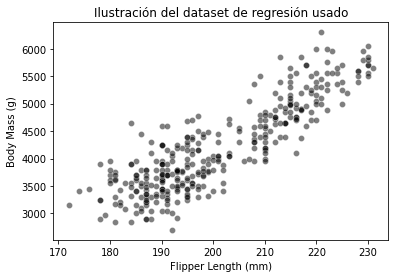

In [18]:
sns.scatterplot(data=penguins, x=feature_name, y=target_name,
                color="black", alpha=0.5)
_ = plt.title("Ilustración del dataset de regresión usado")

En primer lugar, ilustraremos la diferencia entre un modelo lineal y un ábol de decisión.

In [19]:
from sklearn.linear_model import LinearRegression

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_predicted = linear_model.predict(X_test)

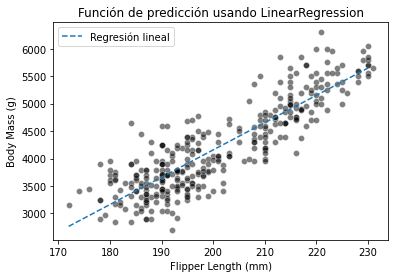

In [20]:
sns.scatterplot(data=penguins, x=feature_name, y=target_name,
                color="black", alpha=0.5)
plt.plot(X_test[feature_name], y_predicted, label="Regresión lineal",
         linestyle="--")
plt.legend()
_ = plt.title("Función de predicción usando LinearRegression")

En la gráfica anterior, vemos que una `LinearRegression` no regularizada es capaz de entrenar los datos. Una característica de este modelo es que todas las nuevas predicciones estarán en la línea.

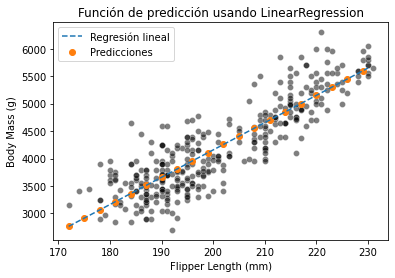

In [21]:
sns.scatterplot(data=penguins, x=feature_name, y=target_name,
                color="black", alpha=0.5)
plt.plot(X_test[feature_name], y_predicted, label="Regresión lineal",
         linestyle="--")
plt.scatter(X_test[::3], y_predicted[::3], label="Predicciones",
            color="tab:orange")
plt.legend()
_ = plt.title("Función de predicción usando LinearRegression")

Al contrario que los modelos lineales, los árboles de decisión son modelos no paramétricos: no hacen asunciones sobre la forma en que se distribuyen los datos. Esto afectará al esquema de predicción. Destacaremos las diferencias repitiendo el experimento anterior.

In [22]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(max_depth=1)
tree.fit(X_train, y_train)
y_predicted = tree.predict(X_test)

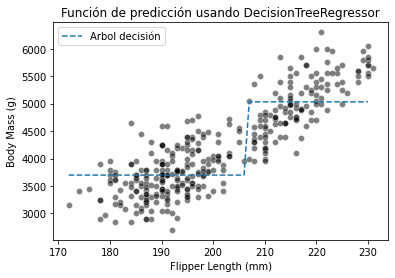

In [23]:
sns.scatterplot(data=penguins, x=feature_name, y=target_name,
                color="black", alpha=0.5)
plt.plot(X_test[feature_name], y_predicted, label="Arbol decisión",
         linestyle="--")
plt.legend()
_ = plt.title("Función de predicción usando DecisionTreeRegressor")

Como vemos, el modelo de árbol de decisión no tiene una distribución *a priori* de los datos y no termina con una línea recta para correlar el tamaño de la aleta y la masa corporal.

En su lugar, observamos que las predicciones del árbol son constantes por tramos. De hecho, nuestro espacio de features se dividió en dos particiones. Vamos a comprobar la estructura del árbol para ver el umbral encontrado durante el entrenamiento.

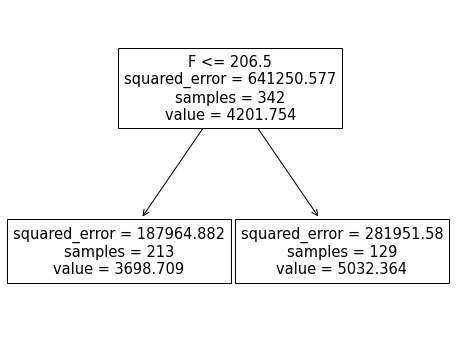

In [24]:
from sklearn.tree import plot_tree

_, ax = plt.subplots(figsize=(8, 6))
_ = plot_tree(tree, feature_names=feature_name, ax=ax)

El umbral para nuestra feature (tamañan de la aleta) es 206.5 mm. Los valores predichos en cada lado de la división son dos constantes: 3698.709 g y 5032.364 g. Esos valores se corresponden con los valores medios de las muestras de entrenamiento de cada partición.

En clasificación, vimos que incrementando la profundidad del árbol obteníamos límites de decisión más complejos. Vamos a comprobar el efecto de incrementar la profundidad en un problema de regresión:

In [25]:
tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X_train, y_train)
y_predicted = tree.predict(X_test)

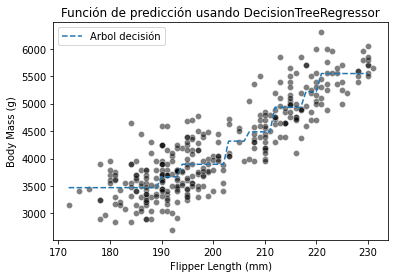

In [26]:
sns.scatterplot(data=penguins, x=feature_name, y=target_name,
                color="black", alpha=0.5)
plt.plot(X_test[feature_name], y_predicted, label="Arbol decisión",
         linestyle="--")
plt.legend()
_ = plt.title("Función de predicción usando DecisionTreeRegressor")

Incrementar la profundidad del árbol incrementará el número de particiones y, por tanto, el número de valores constantes que el árbol es capaz de predecir.

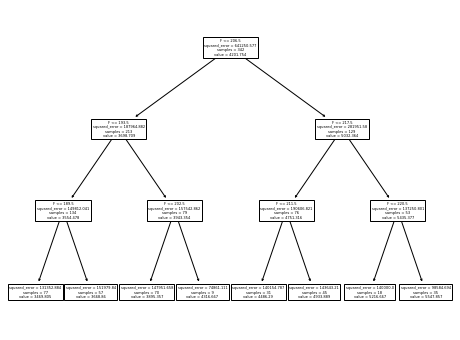

In [27]:
_, ax = plt.subplots(figsize=(8, 6))
_ = plot_tree(tree, feature_names=feature_name, ax=ax)

# Hiperparámetros de árbol de decisión

Vamos a mostrar la importancia de algunos hiperparámetros clave en los árboles de decisión y demostraremos sus efectos en problemas de clasificación y regresión.

En primer lugar, cargaremos los datasets de clasificación y regresión.

In [28]:
data_clf_columns = ["Culmen Length (mm)", "Culmen Depth (mm)"]
target_clf_column = "Species"
data_clf = pd.read_csv("../data/penguins_classification.csv")

In [29]:
data_reg_columns = ["Flipper Length (mm)"]
target_reg_column = "Body Mass (g)"
data_reg = pd.read_csv("../data/penguins_regression.csv")

## Creación de helpers

Vamos a crear algunas funciones helpers para dibujar las muestras de datos así como los límites de decisión para la clasificación y las líneas de regresión para la regresión.

In [30]:
from helpers.plotting import DecisionBoundaryDisplay


def fit_and_plot_classification(model, data, feature_names, target_names):
    model.fit(data[feature_names], data[target_names])
    if data[target_names].nunique() == 2:
        palette = ["tab:red", "tab:blue"]
    else:
        palette = ["tab:red", "tab:blue", "black"]
    DecisionBoundaryDisplay.from_estimator(
        model, data[feature_names], response_method="predict",
        cmap="RdBu", alpha=0.5
    )
    sns.scatterplot(data=data, x=feature_names[0], y=feature_names[1],
                    hue=target_names, palette=palette)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


def fit_and_plot_regression(model, data, feature_names, target_names):
    model.fit(data[feature_names], data[target_names])
    data_test = pd.DataFrame(
        np.arange(data.iloc[:, 0].min(), data.iloc[:, 0].max()),
        columns=data[feature_names].columns,
    )
    target_predicted = model.predict(data_test)

    sns.scatterplot(
        x=data.iloc[:, 0], y=data[target_names], color="black", alpha=0.5)
    plt.plot(data_test.iloc[:, 0], target_predicted, linewidth=4)

## Efecto del parámetro `max_depth`

El hiperparámetro `max_depth` controla la complejidad global de un árbol de decisión. Este hiperparámetro permite obtener un equilibrio entre underfit y overfit. Vamos a construir un árbol poco profundo y después otro más profundo, tanto para clasificación como para regresión, para comprender el impacto del parámetro.

Primero podemos establecer el parámetro `max_depth` a un valor muy bajo.

In [31]:
max_depth = 2
tree_clf = DecisionTreeClassifier(max_depth=max_depth)
tree_reg = DecisionTreeRegressor(max_depth=max_depth)

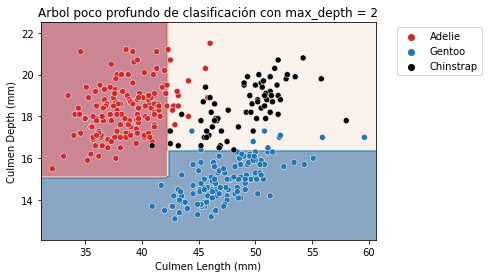

In [32]:
fit_and_plot_classification(
    tree_clf, data_clf, data_clf_columns, target_clf_column)
_ = plt.title(f"Arbol poco profundo de clasificación con max_depth = {max_depth}")

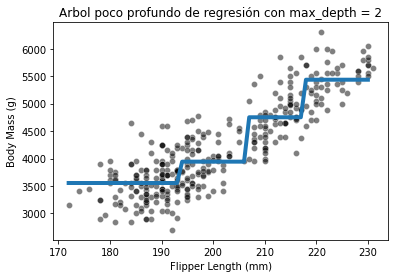

In [33]:
fit_and_plot_regression(
    tree_reg, data_reg, data_reg_columns, target_reg_column)
_ = plt.title(f"Arbol poco profundo de regresión con max_depth = {max_depth}")

Ahora incrementemos el parámetro `max_depth` para comprobar la diferencia observando la función de decisión.

In [34]:
max_depth = 30
tree_clf = DecisionTreeClassifier(max_depth=max_depth)
tree_reg = DecisionTreeRegressor(max_depth=max_depth)

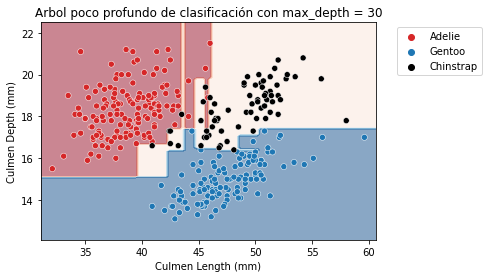

In [35]:
fit_and_plot_classification(
    tree_clf, data_clf, data_clf_columns, target_clf_column)
_ = plt.title(f"Arbol poco profundo de clasificación con max_depth = {max_depth}")

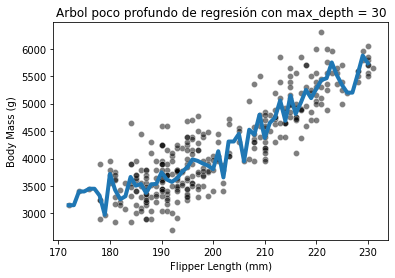

In [36]:
fit_and_plot_regression(
    tree_reg, data_reg, data_reg_columns, target_reg_column)
_ = plt.title(f"Arbol poco profundo de regresión con max_depth = {max_depth}")

Tanto para clasificación como regresión observamos que incrementar la profundidad nos hará el modelo más expresivo. Sin embargo, un árbol que es demasiado profundo sufrirá de overfitting, creando particiones que solo son correctas para "valores atípicos" (muestras ruidosas). `max_depth` es uno de los hiperparámetros que se debe optimizar a través de validación cruzada y grid search.

In [37]:
from sklearn.model_selection import GridSearchCV

param_grid = {"max_depth": np.arange(2, 10, 1)}
tree_clf = GridSearchCV(DecisionTreeClassifier(), param_grid=param_grid)
tree_reg = GridSearchCV(DecisionTreeRegressor(), param_grid=param_grid)

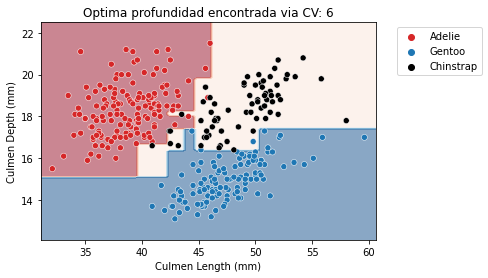

In [38]:
fit_and_plot_classification(
    tree_clf, data_clf, data_clf_columns, target_clf_column)
_ = plt.title(f"Optima profundidad encontrada via CV: "
              f"{tree_clf.best_params_['max_depth']}")

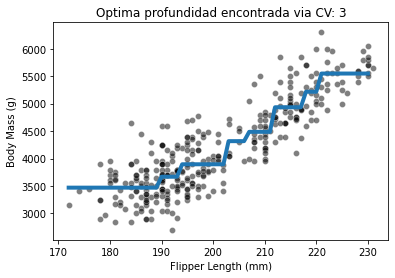

In [39]:
fit_and_plot_regression(
    tree_reg, data_reg, data_reg_columns, target_reg_column)
_ = plt.title(f"Optima profundidad encontrada via CV: "
              f"{tree_reg.best_params_['max_depth']}")

Con este ejemplo, vemos que no existe un único valor que sea óptimo para cada dataset. Por tanto, se requiere que este parámetro sea optimizado para cada aplicación.

## Otros hiperparámetros en áboles de decisión

El hiperparámetro `max_depth` controla la complejidad global del árbol. Este parámetro es adeucado bajo la asunción de que un árbol construido es simétrico. Sin embargo, no hay garantía de que un árbol será simétrico. De hecho, el rendimiento de generalización óptimo se puede alcanzar haciendo crecer algunas ramas más que otras.

Construiremos un dataset donde ilustraremos esta asimetría. Generaremos un dataset compuesto de 2 subconjuntos: un subconjunto donde el árbol debe encontrar una separación clara y otro subconjunto donde las muestras de ambas clases están mezcladas. Esto implica que un árbol de decisión necesitará más divisiones para clasificar adecuadamente las muestras del segundo subconjunto que las del primer subconjunto.

In [40]:
from sklearn.datasets import make_blobs

data_clf_columns = ["Feature #0", "Feature #1"]
target_clf_column = "Class"

# Blobs that will be interlaced
X_1, y_1 = make_blobs(
    n_samples=300, centers=[[0, 0], [-1, -1]], random_state=0)
# Blobs that will be easily separated
X_2, y_2 = make_blobs(
    n_samples=300, centers=[[3, 6], [7, 0]], random_state=0)

X = np.concatenate([X_1, X_2], axis=0)
y = np.concatenate([y_1, y_2])
data_clf = np.concatenate([X, y[:, np.newaxis]], axis=1)
data_clf = pd.DataFrame(
    data_clf, columns=data_clf_columns + [target_clf_column])
data_clf[target_clf_column] = data_clf[target_clf_column].astype(np.int32)

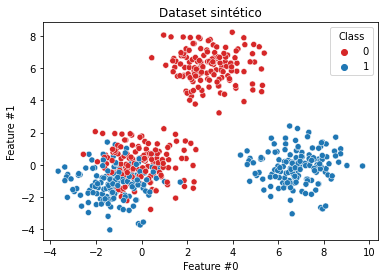

In [41]:
sns.scatterplot(data=data_clf, x=data_clf_columns[0], y=data_clf_columns[1],
                hue=target_clf_column, palette=["tab:red", "tab:blue"])
_ = plt.title("Dataset sintético")

Primero entrenaremos un árbol poco profundo con `max_depth=2`. Cabría esperar que esta profundidad sea suficiente para separar los bloques que son fáciles de separar.

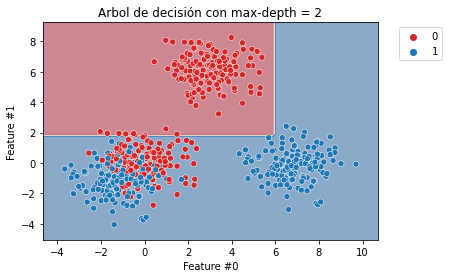

In [42]:
max_depth = 2
tree_clf = DecisionTreeClassifier(max_depth=max_depth)
fit_and_plot_classification(
    tree_clf, data_clf, data_clf_columns, target_clf_column)
_ = plt.title(f"Arbol de decisión con max-depth = {max_depth}")

Como se esperaba, vemos que el bloque azul de la derecha y rojo de la parte superior son fácilmente separables. Sin embargo, se requerirán más divisiones para dividir mejor el bloque donde los puntos de datos rojos y azules están mezclados.

De hecho, vemos que el bloque rojo de la parte superior y el azul de la parte derecha están perfectamente separados. Sin embargo, el árbol aún comete errores en el área donde los bloques están mezclados juntos. Verifiquemos la representación del árbol.

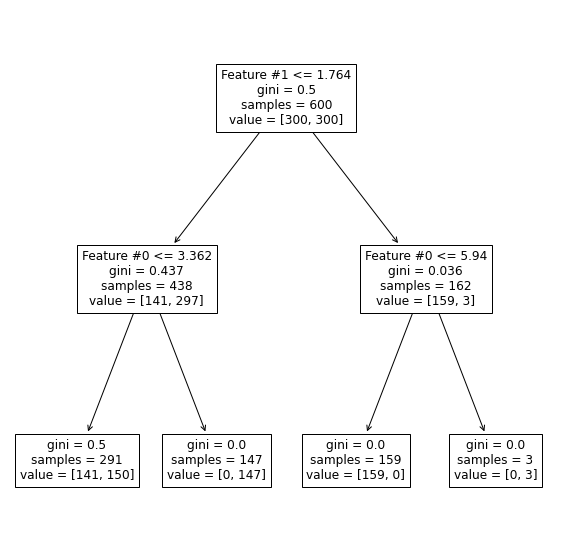

In [43]:
_, ax = plt.subplots(figsize=(10, 10))
_ = plot_tree(tree_clf, ax=ax, feature_names=data_clf_columns)

Vemos que la rama derecha alcanza una clasificación perfecta. Ahora, incrementemos la profundidad para verificar cómo crecerá el árbol.

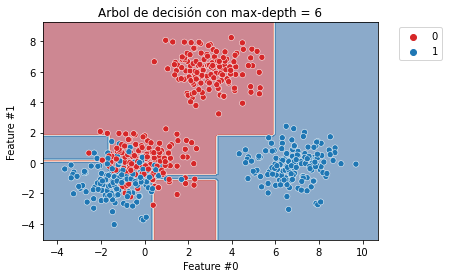

In [44]:
max_depth = 6
tree_clf = DecisionTreeClassifier(max_depth=max_depth)
fit_and_plot_classification(
    tree_clf, data_clf, data_clf_columns, target_clf_column)
_ = plt.title(f"Arbol de decisión con max-depth = {max_depth}")

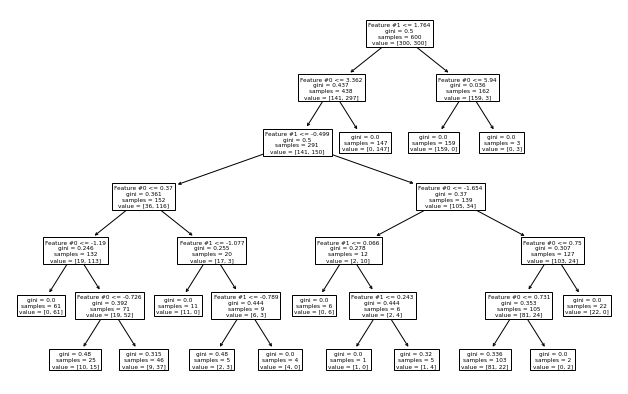

In [45]:
_, ax = plt.subplots(figsize=(11, 7))
_ = plot_tree(tree_clf, ax=ax, feature_names=data_clf_columns)

Como se esperaba, la rama izquierda del árbol continuó creciendo mientras que no se hacían más divisiones en la rama derecha. Fijar el parámetro `max_depth` cortaría el árbol horizontalmente a una nivel específico, ya sea o no más beneficioso que una rama siga creciendo.

Los hiperparámetros `min_samples_leaf`, `min_samples_split`, `max_leaf_nodes` o `min_impurity_decrease` permiten crecimientos asimétricos de árboles y aplicar una restricción a nivel de hojas o nodos. Comprobaremos el efecto de `min_samples_leaf`.

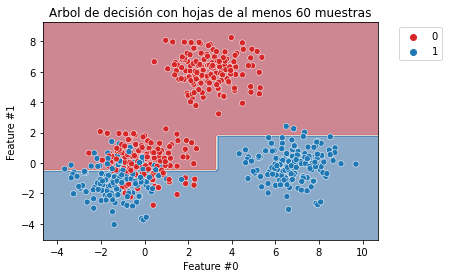

In [46]:
min_samples_leaf = 60
tree_clf = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf)
fit_and_plot_classification(
    tree_clf, data_clf, data_clf_columns, target_clf_column)
_ = plt.title(f"Arbol de decisión con hojas de al menos {min_samples_leaf} muestras")

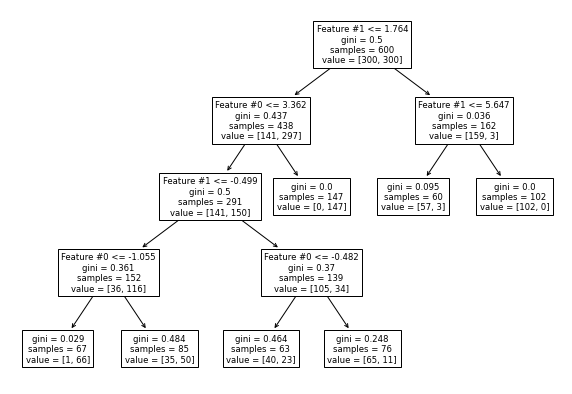

In [47]:
_, ax = plt.subplots(figsize=(10, 7))
_ = plot_tree(tree_clf, ax=ax, feature_names=data_clf_columns)

Este hiperparámetro permite tener hojas con un mínimo número de muestras y, de lo contrario, no se buscarán más divisiones. Por lo tanto, estos hiperparámetros podrían ser una alternativa para corregir el hiperparámetro `max_depth`.

# Ejercicio

Vamos a poner en práctica lo aprendido en este post con un ejemplo. Para ello vamos a usar el dataset `ames_housing_no_missing.csv`.

In [48]:
ames_housing = pd.read_csv("../data/ames_housing_no_missing.csv")
target_name = "SalePrice"
X = ames_housing.drop(columns=target_name)
y = ames_housing[target_name]

Para simplificar sólo utilizaremos las variables numéricas definidas a continuación:

In [49]:
numerical_features = [
    "LotFrontage", "LotArea", "MasVnrArea", "BsmtFinSF1", "BsmtFinSF2",
    "BsmtUnfSF", "TotalBsmtSF", "1stFlrSF", "2ndFlrSF", "LowQualFinSF",
    "GrLivArea", "BedroomAbvGr", "KitchenAbvGr", "TotRmsAbvGrd", "Fireplaces",
    "GarageCars", "GarageArea", "WoodDeckSF", "OpenPorchSF", "EnclosedPorch",
    "3SsnPorch", "ScreenPorch", "PoolArea", "MiscVal",
]

X = X[numerical_features]

Queremos comparar el rendimiendo de generalización de un árbol de decisión y una regresión lineal. Para ello, crearemos dos modelos predictivos por separado y los evaluaremos con una validación cruzada de 10 particiones. Por tanto, usaremos `sklearn.linear_model.LinearRegression` y `sklearn.tree.DecisionTreeRegressor` para crear los modelos. Usaremos los parámetros por defecto para ambos modelos.

Tengamos en cuenta que un modelo lineal requiere escalar las variables numéricas. Por tanto, usaremos `sklearn.preprocessing.StandardScaler`.

**Comparando las puntuaciones de prueba de validación cruzada para ambos modelos, partición a partición, ¿Cuántas veces el modelo lineal es mejor en dicha puntuación que el modelo de árbol de decisión?**

In [50]:
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

linear_model = make_pipeline(StandardScaler(),
                             LinearRegression())
cv_results_lm = cross_validate(linear_model, X, y,
                            cv=10, return_estimator=True)
cv_results_lm["test_score"]

array([0.76129977, 0.80685587, 0.81188989, 0.66592199, 0.79785737,
       0.76868787, 0.74564258, 0.71822127, 0.31479306, 0.78635221])

In [51]:
tree = DecisionTreeRegressor()
cv_results_tree = cross_validate(tree, X, y,
                            cv=10, return_estimator=True)
cv_results_tree["test_score"]

array([0.54944429, 0.71949314, 0.71557951, 0.62398197, 0.72493666,
       0.64684232, 0.47305743, 0.62410671, 0.62849893, 0.72697255])

In [52]:
print(f"¿Cuantas veces es mejor la regresión lineal sobre el árbol de decisión?: "
      f"{sum(cv_results_lm['test_score'] > cv_results_tree['test_score'])} veces")

¿Cuantas veces es mejor la regresión lineal sobre el árbol de decisión?: 9 veces


En lugar de usar los parámetros por defecto para el árbol de decisión regresor, optimizaremos `max_depth` en el árbol. Probaremos `max_depth` desde el nivel 1 al nivel 15. Usaremos validación cruzada anidada para evaluar un grid search. Definamos `cv=10` tanto para la validación cruzada interna como externa.

**¿Cuál es la profundidad óptima para el árbol?**

In [53]:
from sklearn.model_selection import GridSearchCV

param_grid = {"max_depth": np.arange(1, 16, 1)}

tree = GridSearchCV(DecisionTreeRegressor(random_state=42), cv=10, param_grid=param_grid)
cv_results_tree = cross_validate(tree, X, y,
                            cv=10, return_estimator=True)
cv_results_tree["test_score"]

array([0.64240567, 0.76720246, 0.69448254, 0.48481112, 0.76735608,
       0.65537153, 0.66928018, 0.76053576, 0.47306355, 0.70204973])

In [54]:
for estimator in cv_results_tree["estimator"]:
    print(estimator.best_params_)

{'max_depth': 7}
{'max_depth': 5}
{'max_depth': 6}
{'max_depth': 6}
{'max_depth': 8}
{'max_depth': 10}
{'max_depth': 5}
{'max_depth': 6}
{'max_depth': 8}
{'max_depth': 8}


En lugar de usar únicamente las variables numéricas usaremos el dataset completo. Vamos a crear un preprocesador para manejar por separado las variables numéricas y las columnas categóricas. Por simplicidad asumiremos que:

+ las columnas categóricas serán aquellas cuyo tipo de datos es `object`;
+ usaremos un `OrdinalEncoder` para codificar las columnas categóricas;
+ las columnas numéricas serán aquellas cuyo tipo de datos no sea `object`.

Además, estableceremos el parámetro `max_depth` del árbol a `7` y avaluaremos el modelo usando `cross_validate`.

**¿Este modelo es mejor o peor que el entrenado solo con las variables numéricas?**

In [55]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_selector as selector
from sklearn.compose import make_column_transformer
from sklearn.compose import ColumnTransformer

ames_housing = pd.read_csv("../data/ames_housing_no_missing.csv")
target_name = "SalePrice"
X = ames_housing.drop(columns=target_name)
y = ames_housing[target_name]

categorical_processor = OrdinalEncoder(handle_unknown="use_encoded_value",
                                       unknown_value=-1)

preprocessor = make_column_transformer(
     (categorical_processor, selector(dtype_include=object)),
     ("passthrough", selector(dtype_exclude=object))
)

In [56]:
model = make_pipeline(preprocessor,
                      DecisionTreeRegressor(max_depth=7))

cv_results = cross_validate(model, X, y,
                            cv=10, return_estimator=True)
cv_results["test_score"]

array([0.73480057, 0.7919978 , 0.83190014, 0.79477965, 0.81379685,
       0.84669201, 0.5312336 , 0.75213134, 0.59825712, 0.75729819])

La respuesta es que, en este caso, el modelo entrenado con todas las variables (numéricas y categóricas) es mejor que el modelo entrenado únicamente con las variables numéricas.

# Resumen

+ Los árboles de decisión son adecuados tanto para problemas de clasificación como de regresión;
+ son modelos no paramátricos;
+ no son capaces de extrapolar;
+ son sensibles al ajuste de hiperparámetros.

Algunas referencias a seguir con ejemplos de algunos conceptos mencionados:

+ [Ejemplo de árbol de decisión regresor](https://scikit-learn.org/stable/auto_examples/tree/plot_tree_regression.html#sphx-glr-auto-examples-tree-plot-tree-regression-py)
+ [Ejemplo de árbol de decisión clasificador](https://scikit-learn.org/stable/auto_examples/tree/plot_iris_dtc.html#sphx-glr-auto-examples-tree-plot-iris-dtc-py)
+ [Comprensión de la estructura de árbol en scikit-learn](https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html#sphx-glr-auto-examples-tree-plot-unveil-tree-structure-py)
+ [Poda de árboles de decisión](https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html#sphx-glr-auto-examples-tree-plot-cost-complexity-pruning-py)